# Run program

##Prepare

In [73]:
import pandas as pd

In [74]:
!pip install -U pycld2
!pip install pycld3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
import pycld2 as cld2
import cld3

In [76]:
from PIL import Image, ImageFont, ImageDraw 
import json


commonBeneFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSans-Regular.ttf', 90)
commonSponsorFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSans-Regular.ttf', 70)
tradChnBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansTC-Regular.otf', 95)
tradChnSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansTC-Regular.otf', 70)
simpChnBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansSC-Regular.otf', 95)
simpChnSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansSC-Regular.otf', 70)
koreanBeneFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 105)
koreanSponsorFont=ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSansKR-Regular.otf', 80)
idFont = ImageFont.truetype('/content/drive/MyDrive/plaqueGen/NotoSans-Regular.ttf', 30)

def adapter(beneText, sponsorText, plaqueTypeText, plaqueIdNum):
  beneTextFont=commonBeneFont
  beneTextLang="en"

  if beneText.isascii() == False:

    isReliable, textBytesFound, details = cld2.detect(beneText, hintLanguage= 'vi', bestEffort=True)
    beneTextLang=details[0][1]

    if beneTextLang=='un':
      print("using cld3")
      beneTextLang=cld3.get_language(beneText).language
    
    if beneTextLang == 'ko':
      beneTextFont=koreanBeneFont
    elif beneTextLang=='zh':
      beneTextFont=simpChnBeneFont
    elif beneTextLang=='zh-Hant':
      beneTextFont=tradChnBeneFont
    elif beneTextLang=='vi':
      pass
    else:
      return False, {}

  if len(beneText)>19:
    return False, {}

  if sponsorText==beneText:
    sponsorText=""

  sponsorTextFont=commonSponsorFont
  sponsorTextLang="en"

  if sponsorText.isascii() == False:
    if '(' in sponsorText or ')' in sponsorText or u'（' in sponsorText or u'）' in sponsorText:
      return False, {}
      
    isReliable, textBytesFound, details = cld2.detect(sponsorText, hintLanguage= 'vi', bestEffort=True)
    sponsorTextLang=details[0][1]
    
    if sponsorTextLang=='un':
      print("using cld3")
      sponsorTextLang=cld3.get_language(sponsorText).language

    if sponsorTextLang == 'ko':
      sponsorTextFont=koreanSponsorFont
    elif sponsorTextLang=='zh':
      sponsorTextFont=simpChnSponsorFont
    elif sponsorTextLang=='zh-Hant':
      sponsorTextFont=tradChnSponsorFont
    elif sponsorTextLang=='vi':
      pass
    else:
      return False, {}
  
  if len(sponsorText)>28:
    return False, {}

  if "MMB" in plaqueTypeText:
    plaqueType="mmb"
  elif "Rebirth" in plaqueTypeText:
    plaqueType="rebirth"
  else:
    return False, {}


  plaqueId="ChanQi"
  fileName=str.format("ChanQi{0:03}", plaqueIdNum)

  return True, {
"beneText":beneText, 
"beneTextFont":beneTextFont, 
"beneTextLang":beneTextLang,
"sponsorText":sponsorText, 
"sponsorTextFont":sponsorTextFont,
"sponsorTextLang":sponsorTextLang, 
"plaqueId":plaqueId, 
"plaqueIdFont":idFont, 
"plaqueType":plaqueType,
"fileName":fileName,      
  }


def genPlaque(beneText, beneTextFont, beneTextLang, 
              sponsorText, sponsorTextFont, sponsorTextLang,
              plaqueId, plaqueIdFont, 
              plaqueType,
              fileName):
  if plaqueType=="mmb":
    templatePath="/content/drive/MyDrive/plaqueGen/mmb_blank.png"
  elif plaqueType=="rebirth":
    templatePath="/content/drive/MyDrive/plaqueGen/rebirth_blank.png"

  template = Image.open(templatePath)
  canvas = ImageDraw.Draw(template)
  canvas.text((370, 2380), plaqueId, (0, 0, 0), font=plaqueIdFont, anchor='mm')
  
  if beneTextLang in ['ko', 'zh', 'zh-Hant']:
    beneText='\n'.join(beneText)

    canvas.multiline_text((380, 1300), beneText, (0, 0, 0), font=beneTextFont, anchor='mm')


  if sponsorTextLang in ['ko', 'zh', 'zh-Hant']:
    sponsorText='\n'.join(sponsorText)

    canvas.multiline_text((185, 1550), sponsorText, (0, 0, 0), font=sponsorTextFont, anchor='mm')

  text_layer = Image.new("RGBA", (2550, 834), (255, 255, 255, 0))
  textCanvas = ImageDraw.Draw(text_layer)

  if beneTextLang in ['en', 'vi']:
    beneTextCursor=1370-len(beneText)*15
    textCanvas.text((beneTextCursor, 350), beneText, (0, 0, 0, 255), font=beneTextFont, anchor='mm')
  
  if len(sponsorText)<=12:
    sponsortextCursor=1550
  elif len(sponsorText)<=18:
    sponsortextCursor=1350
  elif len(sponsorText)<=23:
    sponsortextCursor=1150
  else:
    sponsortextCursor=950
  
  if sponsorTextLang=='en':
    textCanvas.text((sponsortextCursor, 565), sponsorText, (0, 0, 0, 255), font=sponsorTextFont, anchor='mm')
  elif sponsorTextLang=='vi':
    textCanvas.text((sponsortextCursor, 550), sponsorText, (0, 0, 0, 255), font=sponsorTextFont, anchor='mm')

  rotated_text_layer = text_layer.rotate(270.0, expand=1)

  out = Image.alpha_composite(template, rotated_text_layer)
  outFile=fileName+".png"
  out.save("/content/drive/MyDrive/plaqueGen/plaques/"+outFile)

  return outFile

def getPlaqueInfo(row, plaqueParam, plaqueFile):
  return {
      
        "id": plaqueFile.split('.')[0],
        "file": plaqueFile,
        "benefiary": plaqueParam["beneText"],
        "requester": plaqueParam["sponsorText"],
        "requestDate": row["Create Date"],
        "expiryDate": "",
        "type": plaqueParam["plaqueType"],
        "searchable": True
    
  }

In [77]:
df=pd.read_csv("/content/drive/MyDrive/plaqueGen/20220528 - ChanQi DA Plaques - LOG.csv")
df=df[df[['Sponsor', 'Plaque #1', 'Beneficiary #1']].isna().any(axis=1)==False]
df['Plaque#1 ID']=df.index*2+1
df['Plaque#2 ID']=df.index*2+2
df['Plaque#1 Success']=True
df['Plaque#2 Success']=True

## run generation code

In [78]:
plaques=[]
for index, row in df.iterrows():
  try:
    canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
    if canGenP1==False:
      df.loc[index,'Plaque#1 Success']=False
    else:
      p1Path=genPlaque(**p1Params)
      plaques.append(getPlaqueInfo(row, p1Params, p1Path))
  except Exception as ex:
    print(ex)
    print(row)
    df.loc[index,'Plaque#1 Success']=False


  try:
    canGenP2, p2Params=adapter(row["Beneficiary #2"], row["Sponsor"], row["Plaque #2"], row["Plaque#2 ID"])
    if canGenP2==False:
      df.loc[index,'Plaque#2 Success']=False
    else:
      p2Path=genPlaque(**p2Params)
      plaques.append(getPlaqueInfo(row, p2Params, p2Path))
  except:
    print(row)
    df.loc[index,'Plaque#2 Success']=False

io=open("/content/drive/MyDrive/plaqueGen/plaques/plaques.json", "w")
json.dump(plaques,io)
io.close()

Sponsor                          Diego
Plaque #1                      Rebirth
Beneficiary #1          Grace Deguzman
Plaque #2                          NaN
Beneficiary #2                     NaN
Branch (Temple Name)               NaN
Notes                              NaN
Create Date                        NaN
Plaque#1 ID                        105
Plaque#2 ID                        106
Plaque#1 Success                  True
Plaque#2 Success                  True
Name: 52, dtype: object


# plaques we are not able to generate

In [79]:
df[(df[['Plaque#1 Success', 'Plaque#2 Success']]==False).any(axis=1)]
# [['Sponsor', 'Plaque #1', 'Beneficiary #1', 'Plaque #2', 'Beneficiary #2']]

,Sponsor,Plaque #1,Beneficiary #1,Plaque #2,Beneficiary #2,Branch (Temple Name),Notes,Create Date,Plaque#1 ID,Plaque#2 ID,Plaque#1 Success,Plaque#2 Success
7,陳瑞珠 (入了) Nhập Liểu,MMB1,黃素香,MMB1,黃素梅,GF,Emituofo,5/10/2022 0:39:09,15,16,False,False
8,Huỳnh Đại Tuấn (入知),MMB1,Trịnh Thị Cương,Rebirth1,陳恒光,GF,Emituafo,5/10/2022 0:42:44,17,18,False,False
9,顧榕萍（Grace Gu）,MMB1,鄭歆媛,MMB1,鄭劍飛,WMT,阿彌陀佛,5/10/2022 6:17:11,19,20,False,False
14,Le Kim Du,Kenneth Lee,Kenneth Lee,MMB1,Karen Lee,WMT,Thank you 🙏,5/10/2022 10:24:09,29,30,False,True
15,Ebele Zuidema,Rebirth1,Lutske Zuidema-Reitsma,Rebirth1,Jan Siebren Zuidema,DDT,Amituofo,5/10/2022 12:49:54,31,32,False,False
23,Kelly On,MMB1,李東成,MMB1,李潤鴻,WMT,Apple’s mom,5/10/2022 21:11:56,47,48,False,True
25,Lien Le,MMB1,Luu Thi Mau,MMB1,Andrew Le Ba Quang Bao,GF,Chan Qi,5/10/2022 22:03:04,51,52,True,False
52,Diego,Rebirth,Grace Deguzman,NaN,NaN,NaN,NaN,NaN,105,106,True,False
60,Martina,MMB,Martina Vazquez,MMB1,Marco Antonio Vazquez,WMT,This is my son’s name beneficiare 2. The other...,5/11/2022 22:07:22,121,122,True,False
63,WT Sunim,Manic,WT Sunim,Depression,WT Sunim,NaN,xs,NaN,127,128,False,False


#Debug, please ignore



In [ ]:
plaques[1]["requestDate"], df.iloc[10]["Create Date"]

(nan, '5/10/2022 8:01:39')

In [61]:
row=df.iloc[31]
canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
row, canGenP1, p1Params

(Sponsor                            Xìan Fa
 Plaque #1                             MMB1
 Beneficiary #1                         김대훈
 Plaque #2                             MMB1
 Beneficiary #2                         박혜진
 Branch (Temple Name)                   JMT
 Notes                                   na
 Create Date             5/11/2022 16:21:17
 Plaque#1 ID                             65
 Plaque#2 ID                             66
 Plaque#1 Success                     False
 Plaque#2 Success                     False
 Name: 32, dtype: object, False, {})

In [53]:


# name=df.loc[23
      
#             , 'Beneficiary #1']
name=u"박혜진"
cld2.detect(
    name, hintLanguage= 'vi', bestEffort=True
)



# True
# name, name.isascii(), details[0][1], 

# cld3.get_frequent_languages(name, 2), cld3.get_language(name).language, cld3.get_language(name*3)

(True,
 11,
 (('Korean', 'ko', 90, 3686.0),
  ('Unknown', 'un', 0, 0.0),
  ('Unknown', 'un', 0, 0.0)))

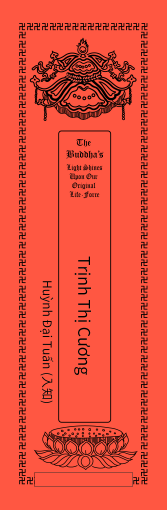

In [ ]:



index=8
row=df.iloc[index]

beneText=row["Beneficiary #1"]
beneTextLang='vi'
beneTextFont=vietBeneFont
# beneTextFont=englishBeneFont
sponsorText=row["Sponsor"]
sponsorTextLang='vi'
sponsorTextFont=vietSponsorFont

# canGenP1, p1Params=adapter(row["Beneficiary #1"], row["Sponsor"], row["Plaque #1"], row["Plaque#1 ID"])
# p1Params
# beneText=p1Params["beneText"]
# beneTextLang=p1Params["beneTextLang"]
# beneTextFont=p1Params["beneTextFont"]
# # beneTextFont=englishBeneFont
# sponsorText=p1Params["sponsorText"]
# sponsorTextLang=p1Params["sponsorTextLang"]
# sponsorTextFont=p1Params["sponsorTextFont"]

if beneText in ['zh', 'zh-Hant', 'ko']:
  beneText='\n'.join(beneText)

templatePath="/content/drive/MyDrive/plaqueGen/mmb_blank.png"

template = Image.open(templatePath)
canvas = ImageDraw.Draw(template)

# canvas.multiline_text((370, 1200), beneText, (0, 0, 0), font=beneTextFont, anchor='mm')

text_layer = Image.new("RGBA", (2550, 834), (255, 255, 255, 0))
textCanvas = ImageDraw.Draw(text_layer)

textCanvas.text((1280, 350), beneText, (0, 0, 0, 255), font=beneTextFont, anchor='mm')

textCanvas.text((1400, 550), sponsorText, (0, 0, 0, 255), font=sponsorTextFont, anchor='mm')
rotated_text_layer = text_layer.rotate(270.0, expand=1)

out = Image.alpha_composite(template, rotated_text_layer)
display(out.reduce(5))

In [18]:
commonBeneFont.getsize(u'Xìan Fa'), commonBeneFont.getsize(u'aaa'), commonBeneFont.getsize(u'Cảnh')

((302, 98), (150, 97), (219, 98))

In [68]:
row=df.iloc[31]
beneText=row['Beneficiary #1']
sponsorText=row['Sponsor']
plaqueTypeText=row['Plaque #1']
beneTextFont=commonBeneFont
beneTextLang="en"

if beneText.isascii() == False:

  isReliable, textBytesFound, details = cld2.detect(beneText, hintLanguage= 'vi', bestEffort=True)
  beneTextLang=details[0][1]

  if beneTextLang=='un':
    print("using cld3")
    beneTextLang=cld3.get_language(beneText).language
  
  if beneTextLang == 'ko':
    beneTextFont=koreanBeneFont
  elif beneTextLang=='zh':
    beneTextFont=simpChnBeneFont
  elif beneTextLang=='zh-Hant':
    beneTextFont=tradChnBeneFont
  elif beneTextLang=='vi':
    pass
  else:
    print("e1")

if len(beneText)>19:
  print("e2")

if sponsorText==beneText:
  sponsorText=""

sponsorTextFont=commonSponsorFont
sponsorTextLang="en"

if sponsorText.isascii() == False:
  if '(' in sponsorText or ')' in sponsorText or u'（' in sponsorText or u'）' in sponsorText:
    print("e3")
    
  isReliable, textBytesFound, details = cld2.detect(sponsorText, hintLanguage= 'vi', bestEffort=True)
  sponsorTextLang=details[0][1]
  print(sponsorTextLang)
  if sponsorTextLang=='un':
    print("using cld3")
    sponsorTextLang=cld3.get_language(sponsorText).language

  if sponsorTextLang == 'ko':
    sponsorTextFont=koreanSponsorFont
  elif sponsorTextLang=='zh':
    sponsorTextFont=simpChnSponsorFont
  elif sponsorTextLang=='zh-Hant':
    sponsorTextFont=tradChnSponsorFont
  elif sponsorTextLang=='vi':
    pass
  else:
    print("e4")

if len(sponsorText)>28:
  print("e5")

if "MMB" in plaqueTypeText:
  plaqueType="mmb"
elif "Rebirth" in plaqueTypeText:
  plaqueType="rebirth"
else:
  print("e6")


vi
